In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import pandas as pd

import sys
sys.path += ['../src']

from utils_audio import get_frames_from_interval

# define the parameters
W_LEN_SEC = 0.96
HOP_SEC = 0.48

# define the paths of the output directories where results are stored
OUTPUT_ASIS_DIR = "../data/yamnet_asis_predictions_test_audio_files"
OUTPUT_TL_DIR = "../data/yamnet_tl_predictions_test_audio_files"

2024-08-08 13:05:47.837330: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-08 13:05:47.863743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


This notebook illustrates how to read the outputs of the `run_yamnet.py` script. Please, run the following commands to generate the outputs:
    
```bash
python run_yamnet.py --audio-data-fold test_audio_files --output-fold data/yamnet_asis_predictions_test_audio_files --save-embeddings true --save-spectrogram true
```
which runs the YAMNet as-is model on some test audio files and saves the predictions, embeddings, and spectrograms in the `data/yamnet_asis_predictions_test_audio_files` folder.

Also run:
```bash
python run_yamnet.py --audio-data-fold test_audio_files --classifier-weights-fold models/ffnn_classifier_yamnet --output-fold data/yamnet_tl_predictions_test_audio_files --save-embeddings true --save-spectrogram true
```
which runs the YAMNet TL model on some test audio files and saves the predictions, embeddings, and spectrograms in the `data/yamnet_tl_predictions_test_audio_files` folder.

In [2]:
# show the content of the audio data folder: four audio files
os.listdir('../test_audio_files')

['STP01_20230302_183002_cut.wav',
 'STP03_20230322_193002_cut.wav',
 'STP01_20230315_200002_cut.wav',
 'STP01_20230216_193002_cut.wav']

### Structure of the output folder

The output folder contains the following folders:
- `metadata`: contains the metadata of the audio files (e.g., duration, sample rate, etc.)
- `scores`: contains the predictions in `.npz` format for each audio file (compressed sparse matrix). It consists of a matrix with shape `(n_samples, n_classes)` where `n_samples` is the number of audio subsegments in an audio file and `n_classes` is the number of classes in YAMNet. The entries of the matrix corresponds to the probability of the class being present in the subsegment. Each subsegment is 0.96 seconds long.


In [3]:
# list the content of the output directory
os.listdir(OUTPUT_ASIS_DIR)

['spectrograms', 'embeddings', 'scores', 'metadata']

In [17]:
# list the content of the output directory
# the YAMNet TL model has one additional folder, 'scores_tl', which contains the scores of the transfer learning model
# the 'scores' folder contains the scores of the YAMNet as-is model
os.listdir(OUTPUT_TL_DIR)

['scores_tl', 'spectrograms', 'embeddings', 'scores', 'metadata']

In [4]:
# the class names of the YAMNet as-is model are stored in a txt file
# the file is saved when the 'run_yamnet' script is executed
yamnet_class_names = open("../data/class_names.txt", "rt").read().splitlines()

print("Total number of classes: ", len(yamnet_class_names))

# show all the classes related to wind - we consider only 277, 279, and 305 as wind-related classes
[(i, name) for i, name in enumerate(yamnet_class_names) if 'wind' in name.lower()]

Total number of classes:  521


[(190, 'Wind instrument, woodwind instrument'),
 (201, 'Wind chime'),
 (277, 'Wind'),
 (279, 'Wind noise (microphone)'),
 (305, 'Power windows, electric windows')]

In [5]:
wind_classes_idx = [277, 279, 305]

### Read the predictions

Note that this works the same for both the as-is and TL models.

In [6]:
# list the files with the prediction scores: one file per audio recording
pred_scores_file = os.listdir(os.path.join(OUTPUT_ASIS_DIR, 'scores'))
pred_scores_file

['STP01_20230315_200002_cut.npz',
 'STP01_20230302_183002_cut.npz',
 'STP01_20230216_193002_cut.npz',
 'STP03_20230322_193002_cut.npz']

In [7]:
# let's load the content of the first file
meta = json.load(open(os.path.join(OUTPUT_ASIS_DIR, 'metadata', pred_scores_file[0].replace('.npz', '.json'))))
out_scores = sparse.load_npz(os.path.join(OUTPUT_ASIS_DIR, 'scores', pred_scores_file[0]))

print("Duration of the audio recording (seconds): ", meta['duration'])
print("Number of rows (subsegments): ", out_scores.shape[0])
print("Number of columns (audio sound classes): ", out_scores.shape[1])

# the file is a sparse matrix -> convenient for storage because most of the values are zeros
# and easy to convert to numpy array
out_scores = out_scores.toarray()
out_scores.shape

Duration of the audio recording (seconds):  120.0
Number of rows (subsegments):  249
Number of columns (audio sound classes):  521


(249, 521)

Subsegments refer to 0.96-long audio segments. Consecutive subsegments are overlapped by 0.48 seconds. To extract the predictions obtained for a custom audio segment that goes from a start to and end time (in seconds), you can use the `get_frames_from_interval` function. This function returns the rows of the prediction matrix referring to the interval of interest.

In [8]:
# extract the rows corresponding to the first second of the audio recording
# these are the first three rows. Indeed, the first three subsegments refers to the following intervals:
# 0.0-0.96, 0.48-1.44, 0.96-1.92
# All these intervals include the interval of interest.
get_frames_from_interval(0, 1, W_LEN_SEC, HOP_SEC)

[0, 1, 2]

In [9]:
# to get the wind score prediction of a 5-second long interval, we take the average of the scores of the corresponding subsegments
idxs = get_frames_from_interval(0, 5, W_LEN_SEC, HOP_SEC)
pred_score_interval = out_scores[idxs].mean(axis=0)

# one value for each class
pred_score_interval.shape

(521,)

In [10]:
# the wind score is the maximum of the scores of the wind-related classes
wind_score = pred_score_interval[wind_classes_idx].max()
wind_score

0.04398567

### Compare the predictions with the annotations

In [11]:
# read the annotation file
annotations_df = pd.read_csv("../data/annotation_5sec/annotations_test_audio_files.csv")
annotations_df.head()

,file_name,segment_start_s,wind,wind_strength,animal_sound,penguin_sound_type,rain
0,STP01_20230315_200002_cut.wav,0.0,0,absent,0,absent,0
1,STP01_20230315_200002_cut.wav,5.0,0,absent,0,absent,0
2,STP01_20230315_200002_cut.wav,10.0,0,absent,0,absent,0
3,STP01_20230315_200002_cut.wav,15.0,0,absent,0,absent,0
4,STP01_20230315_200002_cut.wav,20.0,1,low,0,absent,0


In [12]:
# get the wind scores for all the 5-second long intervals

wind_scores_yamnet_asis_df = []
for file in pred_scores_file:

    # read the prediction scores
    meta = json.load(open(os.path.join(OUTPUT_ASIS_DIR, 'metadata', pred_scores_file[0].replace('.npz', '.json'))))
    out_scores = sparse.load_npz(os.path.join(OUTPUT_ASIS_DIR, 'scores', pred_scores_file[0]))
    out_scores = out_scores.toarray()

    # get the wind scores for all the 5-second long intervals
    for i in range(0, int(meta['duration']), 5):
        idxs = get_frames_from_interval(i, i + 5, W_LEN_SEC, HOP_SEC)
        
        if idxs[-1] >= out_scores.shape[0]:
            # adjust the indexes if out of range
            idxs = [idx for idx in idxs if idx < out_scores.shape[0]]

        # average the scores of the subsegments
        pred_score_interval = out_scores[idxs].mean(axis=0)

        # take the max of the scores of the wind-related classes
        wind_score = pred_score_interval[wind_classes_idx].max()

        wind_scores_yamnet_asis_df.append({
            'file_name': file.replace('.npz', '.wav'),
            'segment_start_s': i,
            'wind_score': wind_score
        })
    
wind_scores_yamnet_asis_df = pd.DataFrame(wind_scores_yamnet_asis_df)

# merge the wind scores with the annotations
wind_scores_yamnet_asis_df = pd.merge(annotations_df, wind_scores_yamnet_asis_df, on=['file_name', 'segment_start_s'], how='left')
wind_scores_yamnet_asis_df.head()

,file_name,segment_start_s,wind,wind_strength,animal_sound,penguin_sound_type,rain,wind_score
0,STP01_20230315_200002_cut.wav,0.0,0,absent,0,absent,0,0.043986
1,STP01_20230315_200002_cut.wav,5.0,0,absent,0,absent,0,0.068171
2,STP01_20230315_200002_cut.wav,10.0,0,absent,0,absent,0,0.042841
3,STP01_20230315_200002_cut.wav,15.0,0,absent,0,absent,0,0.062107
4,STP01_20230315_200002_cut.wav,20.0,1,low,0,absent,0,0.094659


<Axes: xlabel='wind', ylabel='wind_score'>

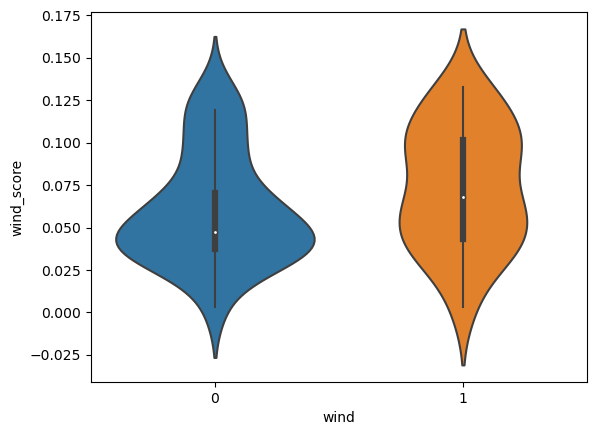

In [13]:
# show the distribution of wind scores for the wind and non-wind segments
sns.violinplot(data=wind_scores_yamnet_asis_df, x='wind', y='wind_score')

In [19]:
# do the same for the wind scores of the yamnet TL model

wind_scores_yamnet_tl_df = []
for file in pred_scores_file:

    # read the prediction scores
    meta = json.load(open(os.path.join(OUTPUT_TL_DIR, 'metadata', pred_scores_file[0].replace('.npz', '.json'))))
    out_scores = sparse.load_npz(os.path.join(OUTPUT_TL_DIR, 'scores_tl', pred_scores_file[0]))
    out_scores = out_scores.toarray()

    # get the wind scores for all the 5-second long intervals
    for i in range(0, int(meta['duration']), 5):
        idxs = get_frames_from_interval(i, i + 5, W_LEN_SEC, HOP_SEC)
        
        if idxs[-1] >= out_scores.shape[0]:
            # adjust the indexes if out of range
            idxs = [idx for idx in idxs if idx < out_scores.shape[0]]

        # average the scores of the subsegments
        pred_score_interval = out_scores[idxs].mean(axis=0)[0]

        # NOTE: differently from YAMNet as-is, YAMNet TL returns one single value for the wind score
        wind_score = pred_score_interval

        wind_scores_yamnet_tl_df.append({
            'file_name': file.replace('.npz', '.wav'),
            'segment_start_s': i,
            'wind_score': wind_score
        })
    
wind_scores_yamnet_tl_df = pd.DataFrame(wind_scores_yamnet_tl_df)

# merge the wind scores with the annotations
wind_scores_yamnet_tl_df = pd.merge(annotations_df, wind_scores_yamnet_tl_df, on=['file_name', 'segment_start_s'], how='left')
wind_scores_yamnet_tl_df.head()

,file_name,segment_start_s,wind,wind_strength,animal_sound,penguin_sound_type,rain,wind_score
0,STP01_20230315_200002_cut.wav,0.0,0,absent,0,absent,0,0.332476
1,STP01_20230315_200002_cut.wav,5.0,0,absent,0,absent,0,0.517529
2,STP01_20230315_200002_cut.wav,10.0,0,absent,0,absent,0,0.380628
3,STP01_20230315_200002_cut.wav,15.0,0,absent,0,absent,0,0.365441
4,STP01_20230315_200002_cut.wav,20.0,1,low,0,absent,0,0.524141


<Axes: xlabel='wind', ylabel='wind_score'>

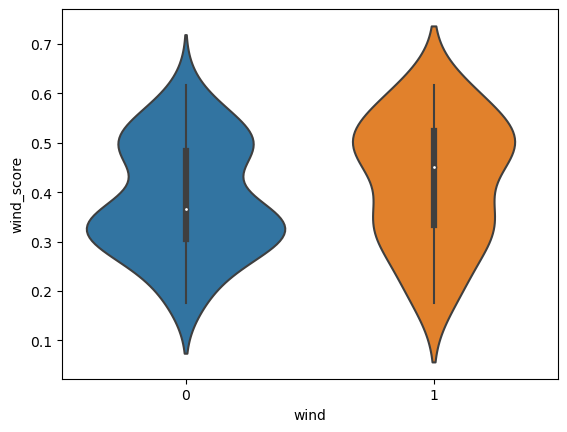

In [24]:
# show the distribution of wind scores for the wind and non-wind segments
sns.violinplot(data=wind_scores_yamnet_tl_df, x='wind', y='wind_score')